## Binary Classification CNN Model

In this notebook, I delve into exploring the parameters of a CNN model to obtain high recall metric using a retinal image dataset. After tackling a multi-class classification model, to which the dataset was originally created for, I have decided to combine some of my classes and work on a binary classification. Even with the combination of classes, one class still holds 70% of the data keeping the dataset imbalance. My approach to tackling the data imbalance is to optimize the CNN model with class-weight in training to weight my minority class more than my majority as well as adding image augmentation to my minority set only to provide more diversity to the training set. 

In [1]:
import numpy as np
import pandas as pd
import os # for file handling
import PIL # for image handling
from PIL import Image # for image handling
import matplotlib.pyplot as plt 
from keras import backend as K # for model evaluation
import tensorflow as tf # for machine learning
from keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split # for splitting the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for data augmentation
from tensorflow.keras.models import Sequential # for model creation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalMaxPooling2D 
from tensorflow.keras import regularizers 
from tensorflow.keras.applications import ResNet50 # for transfer learning
from tensorflow.keras.metrics import Precision, Recall, BinaryCrossentropy # for model evaluation
from tensorflow.keras.optimizers import SGD # for model optimization
from sklearn.utils.class_weight import compute_sample_weight # for class weights
from tensorflow.keras.callbacks import EarlyStopping # for early stopping
from tensorflow.keras import callbacks # for model checkpoint
from sklearn.metrics import roc_curve, auc # for model evaluation
from sklearn.metrics import accuracy_score # for model evaluation
from sklearn.metrics import classification_report # for model evaluation
from sklearn.metrics import precision_recall_curve # for model evaluation


In [2]:
#The following three codes is used when using google colab for higher GPU performance
#from google.colab import auth
#auth.authenticate_user()

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#base_image_dir = os.path.join('/content/drive/MyDrive/train')
#image_dataset = pd.read_csv('/content/drive/MyDrive/train/train_score_dec29.csv')
#the images are not annotated with classes, so we need to join the csv file with the image names and labels with the images in a single path.
#base_image_dir = os.path.join(folder)
#image_dataset = pd.read_csv(labels)
#image_dataset['PatientId'] = image_dataset['image'].map(lambda x: x.split('_')[0]) #getting the image ID from the image name
#image_dataset['path'] = image_dataset['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x))) #creating a new column and appending the full file path for each image.

#image_dataset['exists'] = image_dataset['path'].map(os.path.exists) #making sure that every image exists in the labels csv and the image itself.


#print(image_dataset['exists'].sum(), 'images found of', image_dataset.shape[0], 'total') #print how many images are found in the csv and images.
#image_dataset['eye'] = image_dataset['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0) #creating a binary column for left and right eye image. left = 1 and right =0.

#image_dataset['level_cat'] = image_dataset['level'].map(lambda x: to_categorical(x, 1+image_dataset['level'].max())) # creating a categorical column that includes one-hot encoded labels for the level of severity.

#image_dataset.dropna(inplace = True)
#image_dataset = image_dataset[image_dataset['exists']]

## Data Loading 

The dataset is read in as a csv file that was created and saved from the Multi-Class Classification Model notebook. The ```level_cat``` column is dropped and classes 1-4 are combined and assigned a binary classification of 1. 

In [5]:
dataset = pd.read_csv('image_dataset.csv')

In [6]:
dataset

,image,level,PatientId,path,exists,eye,level_cat
0,11909_right,0,11909,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,[1. 0. 0. 0. 0.]
1,15652_left,0,15652,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,1,[1. 0. 0. 0. 0.]
2,11098_right,2,11098,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,[0. 0. 1. 0. 0.]
3,10284_right,0,10284,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,[1. 0. 0. 0. 0.]
4,17441_right,0,17441,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,[1. 0. 0. 0. 0.]
...,...,...,...,...,...,...,...
8401,15615_left,2,15615,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,1,[0. 0. 1. 0. 0.]
8402,18516_right,0,18516,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,[1. 0. 0. 0. 0.]
8403,12687_right,0,12687,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,[1. 0. 0. 0. 0.]
8404,13815_right,0,13815,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0,[1. 0. 0. 0. 0.]


In [7]:
binary_dataset = dataset.copy()

In [8]:
binary_dataset['level'] = binary_dataset['level'].apply(lambda x: 0 if x == 0 else 1) #changing the level column to binary, 0 for no DR and 1 for DR.

In [9]:
binary_dataset = binary_dataset.drop(columns=['level_cat']) #dropping the level_cat column as it is not needed for binary classification.

In [10]:
binary_dataset

,image,level,PatientId,path,exists,eye
0,11909_right,0,11909,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0
1,15652_left,0,15652,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,1
2,11098_right,1,11098,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0
3,10284_right,0,10284,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0
4,17441_right,0,17441,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0
...,...,...,...,...,...,...
8401,15615_left,1,15615,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,1
8402,18516_right,0,18516,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0
8403,12687_right,0,12687,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0
8404,13815_right,0,13815,/Users/shivanassori/Desktop/Folders/Data_Scien...,True,0


level
0    6148
1    2258
Name: count, dtype: int64


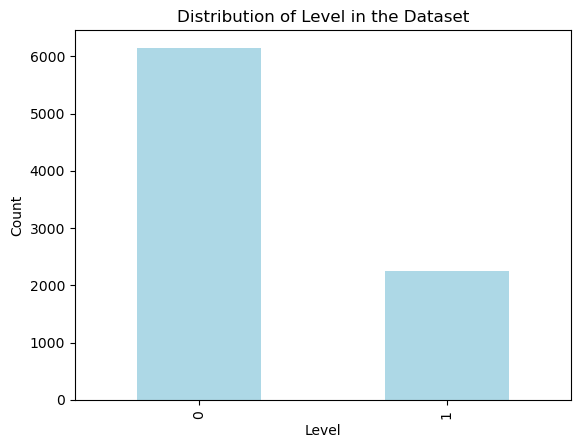

In [11]:
level_counts = binary_dataset['level'].value_counts()
print(level_counts)
level_counts.plot(kind='bar', color='lightblue')
plt.xlabel('Level')
plt.ylabel('Count')
plt.title('Distribution of Level in the Dataset')
plt.show()

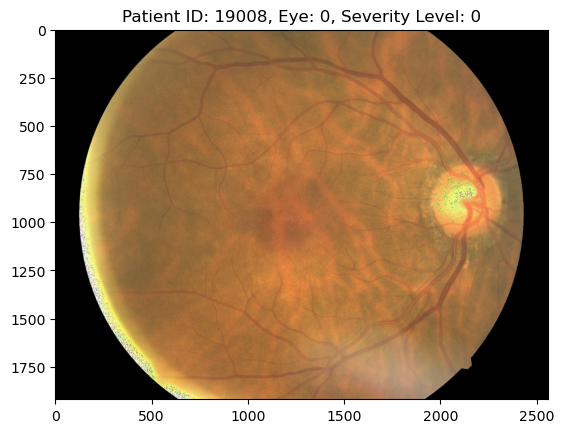

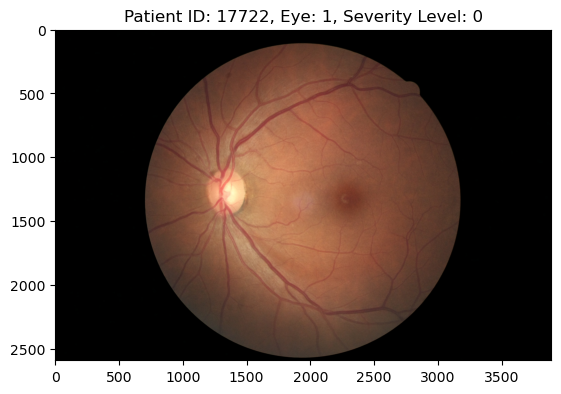

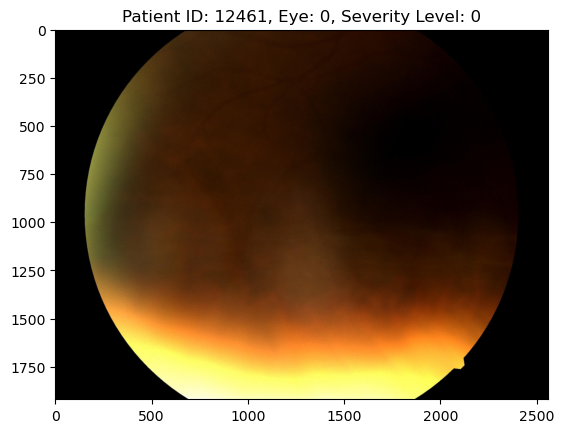

In [12]:
# viewing some images from the dataset
sample_indices = np.random.choice(binary_dataset.index, size=3, replace=False)

for i in sample_indices:
    image = Image.open(binary_dataset.loc[i, 'path'])
    plt.imshow(image)
    plt.title(f"Patient ID: {binary_dataset.loc[i, 'PatientId']}, Eye: {binary_dataset.loc[i, 'eye']}, Severity Level: {binary_dataset.loc[i, 'level']}")
    plt.show()

In [13]:
type(binary_dataset['level'])

pandas.core.series.Series

**Observation** 

The dataset now includes a binary classification yet still an inbalance of data. The target column is ```level``` which contains either a 0 or a 1, 0 inidicating negative for diabetic retinopathy and 1 inidicating positive for diabetic retinopathy. 

## Train-Test Split

The target column in our model is ```level```. In the TensorFlow framework, the target column needs to be in a numpy array because the model expects the input data to be in a numerical format that can be processed efficiently. Therefore, out one-hot encoded target is converted to a numpy array in the following code. Numpy arrays are more memory efficient and faster than Python lists and while training a model, TensorFlow uses the numerical representations to adjust the model's weight through backpropagation. 

In [14]:
y_array = np.array(binary_dataset['level'])

In [15]:
type(y_array)

numpy.ndarray

In [16]:
len(y_array) #checking the length of the array

8406

In [17]:
#splitting the dataset into training and remainder sets. Stratify is used to ensure that the distribution of the classes is the same in both sets.
X_train, X_rem, y_train, y_rem = train_test_split(binary_dataset['path'],y_array, test_size = 0.2, random_state = 42, stratify = y_array)

In [18]:
# splitting the remainder set into validation and test sets. Stratify is used to ensure that the distribution of the classes is the same in both sets.
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state = 42, stratify = y_rem)

In [19]:
len(y_val) #checking the length of the validation set

841

In [20]:
type(y_test) #checking the type of the test set

numpy.ndarray

Now that we have split our data into training, validation, and testing sets, we need to convert the sets into tensors before begining modeling. 
TensorFlow models require the data to be in the form of tensors because of the following reasons: 
1. Efficiency: Tensors are a generalization of matrices to higher dimensrions, and are the fundemental data structure in TensorFlow. 
2. Compatibility: In order to use the full range of TensorFlow's functionality the data needs to be in tensor format. 
3. Batch Processing: To perform batch processing which means that you can perform computations on an entire batch of data points at once, rather than looping over them one by one, the data needs to be in tensor format. This add to efficiency and a main reason why neural networks cna be trained so quickly. 

The following code takes the images and its corresponding label as input for the model. The function reads the ```image_path``` from the dataframe and returns a raw binary data of the image, then decodes the JPEG encoded image and converts the pixel values of the image from integers to floating point and scaling the values. Essentially, this function loads and normalizes the data as input. 

In [21]:
def image_load_preprocessing(image_path, label):
    image = tf.io.read_file(image_path) #tensorflow function that reads image file by image_path and returns a raw binary data of the image
    image = tf.image.decode_jpeg(image, channels =3) #decodes JPEG encoded image from the raw binary data, channel = 3 indicates the image is in color
    image = tf.image.resize(image,[299,299]) #ensuring all the images are the same size
    image = tf.cast(image, tf.float32)/255.0 # converts the pixel values of the image from integers to floating point and then scaling the pixel values
    return image, label

The following function performs image augmentation on the images. This is done to increase diversity and amount of training by including rotations and brightness of the images. This is done only on the minority training set. 

In [22]:
#Image augmentation; randomly flips the image horizontally and randomly changes the brightness of the image
def augment(image,label):
    image = tf.image.random_flip_left_right(image) #randomly flips the image horizontally
    image = tf.image.random_brightness(image, max_delta=0.5) #randomly changes the brightness of the image
    image = tf.image.random_contrast(image, lower=0.0, upper=1.0) #randomly changes the contrast of the image
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0) #randomly changes the saturation of the image
    return image,label

In [23]:
# converting the target variable into tensors. 
y_train_tf = tf.convert_to_tensor(y_train.tolist(), dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val.tolist(), dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test.tolist(), dtype=tf.float32)

In [24]:
type(y_train_tf) #checking the type of the target variable

tensorflow.python.framework.ops.EagerTensor

In the following code, I split the training set into majority and minority to perform image augmentation only on the minority set and concate the sets again for the final train dataset. 

In [25]:
# split the training data into minority and majority classes
minority_indices = (y_train_tf == 1)  # Adjust this condition based on your task
majority_indices = ~minority_indices

minority_dataset = tf.data.Dataset.from_tensor_slices((X_train.values[minority_indices], y_train_tf[minority_indices]))
majority_dataset = tf.data.Dataset.from_tensor_slices((X_train.values[majority_indices], y_train_tf[majority_indices]))

#image loading and preprocessing to both datasets
minority_dataset = minority_dataset.map(image_load_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
majority_dataset = majority_dataset.map(image_load_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#augmentation only to the minority class
minority_dataset = minority_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = minority_dataset.concatenate(majority_dataset)



The following codes show some images from the dataset after image preprocessing to check that the images are not being cropped and properly being resized. 

In [26]:
#sample_images, sample_labels = next(iter(train_dataset.shuffle(1000).batch(3)))

#plt.figure(figsize=(10, 10))
#for i in range(3):
    #ax = plt.subplot(1, 3, i + 1)
    # Multiply by 255 and convert to uint8 if the images were normalized
    #plt.imshow((sample_images[i].numpy() * 255).astype("uint8"))
    #plt.title(f'Class: {sample_labels[i].numpy()}')
    #plt.axis("on")

In [27]:
#class_0_dataset = train_dataset.filter(lambda x, y: tf.equal(y, 0))

#sample_images, sample_labels = next(iter(class_0_dataset.shuffle(1000).batch(3)))

#plt.figure(figsize=(10, 10))
#for i in range(3):
    #ax = plt.subplot(1, 3, i + 1)
    # Select a single image from the batch
    #image = sample_images[i]
    # Multiply by 255 and convert to uint8 if the images were normalized
    #plt.imshow((image.numpy() * 255).astype("uint8"))
    #plt.title(f'Class: {sample_labels[i].numpy()}')
    #plt.axis("off")

In [28]:
# converting the validation sets into tensors
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val_tf))
val_dataset = val_dataset.map(image_load_preprocessing, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [29]:
# converting the test sets into tensors
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test_tf))
test_dataset = test_dataset.map(image_load_preprocessing, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [30]:
#batching the datasets. Switching the order of the shuffle and batch operations can improve the performance of the model. 
#Prefetching is used to improve the performance of the model.
batch_size = 30
train_dataset = train_dataset.shuffle(buffer_size = len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
len(train_dataset) #checking how mnany batches are in the training dataset

225

In [32]:
len(val_dataset) # checking how many batches are in the validation dataset

29

In [33]:
len(test_dataset) #checking how many batches are in the test dataset

29

## Modeling

Now that we have our datasets in tensor format, our training set augmented we can begin the modeling process. The model in this notebook is a CNN (Convolutional Neural Network) model. CNNs are a class of deep learning models that are especially effective for processing grid-like data such as images. They are designed to automatically and adaptively learn spatial hierachies of features from the input data and they are a common approach to building models with medical images. The key components of a CNN are as follows: 
1. Convolutional layer: The core block of a CNN model. The layer's parameters consists of a set of learnable filters/kernels which have a small receptive field, but extend through the full depth of the input volume. During the forward pass, each filter is convolved across the width and height of the input volume, computing the dot product between the entries of the filter and the input and producing a 2D activation map of that filter. Eventually the network learns the filters that activate when it detects some specific type of feature at some spatial position in the input. 
2. Pooling layer: This layer progressively reduces the amount of parameters and computation in the network. Pooling layer operates on each feature map independently. 
3. Fully connected layer: Neurons in a fully connected layer have full connections to all activations in the previous layer. 
4. ReLU layer: The Rectified Linear Unit layer applies the relu activation elemntwise. It is a non-linear operation and does not change the dimenstions of the previous layer. 
5. Softmax/Sigmoid layer: At the end of a CNN model, a softmax or sigmoid activation function is typically used for the final classification, depending on how many classes are in the target.  I apply class weights to the training set and optimize the model to obtain higher recall as the objective of this project is to determine the presence of the disease, even at early stages. 

I apply class weight on the training set to ensure that there is efficient training on both classes in the data. 

In [34]:
class_weights = compute_sample_weight(class_weight='balanced', y=y_train) #computing the class weights for the training dataset
class_weights = dict(enumerate(class_weights)) #converting the class weights into a dictionary for the model to use.

In [35]:
model = Sequential() #creating a sequential model

In [36]:
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'valid', input_shape=(299, 299, 3))) #adding the first convolutional layer
model.add(MaxPooling2D((2, 2))) #adding the first max pooling layer
model.add(Dropout(0.5)) #adding the first dropout layer

model.add(Conv2D(32, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)) 

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001))) #added a regularizer, changed from 0.01 to 0.001
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))) # changed from 0.01 to 0.001
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))) 
model.add(Dense(1, activation='sigmoid')) #output layer with sigmoid activation function for binary classification. 

In [37]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [38]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m]) #compiling the model with the optimizer, loss function and metrics.

In [ ]:
# Assuming you have 'n' classes
model.add(Dense(n, activation='softmax')) # Add this line when you're defining your model architecture

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 148, 148, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 73, 73, 32)        0

In [40]:
#this code is used to save the model with the best validation loss
#early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# this code is used to save the model with the best validation recall
early_stop = callbacks.EarlyStopping(monitor='val_f1_m', patience=3, mode='max', restore_best_weights=True)


In [41]:
#fitting the model to the training dataset and validating it with the validation dataset, with class weights and early stopping.
history = model.fit(train_dataset, epochs=10, validation_data = val_dataset, class_weight=class_weights, callbacks=[early_stop])

Epoch 1/10


2024-02-05 19:17:58.574959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 1000 of 6724
2024-02-05 19:18:08.610603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 2041 of 6724
2024-02-05 19:18:18.621498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 2999 of 6724
2024-02-05 19:18:38.564240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 5023 of 6724
2024-02-05 19:18:48.634739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 6056 of 6724
2024-02-05 19:18:55.964356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


225/225 [==============================] - 330s 1s/step - loss: 4.3098 - accuracy: 0.6093 - f1_m: 0.4893 - precision_m: 0.4008 - recall_m: 0.6978 - val_loss: 4.2437 - val_accuracy: 0.4495 - val_f1_m: 0.3211 - val_precision_m: 0.2382 - val_recall_m: 0.5058
Epoch 2/10


2024-02-05 19:23:28.066540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 870 of 6724
2024-02-05 19:23:48.022189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 2645 of 6724
2024-02-05 19:23:58.056654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 3542 of 6724
2024-02-05 19:24:18.018675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 5282 of 6724
2024-02-05 19:24:28.027753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 6118 of 6724
2024-02-05 19:24:34.837044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


225/225 [==============================] - 336s 1s/step - loss: 3.7541 - accuracy: 0.8392 - f1_m: 0.7231 - precision_m: 0.6819 - recall_m: 0.8153 - val_loss: 3.8546 - val_accuracy: 0.6873 - val_f1_m: 0.0741 - val_precision_m: 0.1609 - val_recall_m: 0.0509
Epoch 3/10


2024-02-05 19:29:03.671684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 829 of 6724
2024-02-05 19:29:23.663163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 2526 of 6724
2024-02-05 19:29:33.669215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 3394 of 6724
2024-02-05 19:29:53.705140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 5100 of 6724
2024-02-05 19:30:13.695631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 6703 of 6724
2024-02-05 19:30:13.947882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


225/225 [==============================] - 396s 1s/step - loss: 3.3704 - accuracy: 0.8971 - f1_m: 0.8099 - precision_m: 0.7920 - recall_m: 0.8582 - val_loss: 3.5720 - val_accuracy: 0.7277 - val_f1_m: 0.0077 - val_precision_m: 0.0345 - val_recall_m: 0.0043
Epoch 4/10


2024-02-05 19:35:39.217173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 824 of 6724
2024-02-05 19:35:49.227565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 1663 of 6724
2024-02-05 19:36:09.205490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 3390 of 6724
2024-02-05 19:36:19.282615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 4231 of 6724
2024-02-05 19:36:39.219475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 5919 of 6724
2024-02-05 19:36:48.533066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


225/225 [==============================] - 371s 1s/step - loss: 3.0304 - accuracy: 0.9390 - f1_m: 0.8864 - precision_m: 0.8911 - recall_m: 0.9037 - val_loss: 3.3463 - val_accuracy: 0.6932 - val_f1_m: 0.0446 - val_precision_m: 0.1092 - val_recall_m: 0.0289


In [42]:
history.history

{'loss': [4.309778213500977,
  3.7541284561157227,
  3.3703510761260986,
  3.0303688049316406],
 'accuracy': [0.6093099117279053,
  0.8392326235771179,
  0.8970850706100464,
  0.9390243887901306],
 'f1_m': [0.48926278948783875,
  0.7230988144874573,
  0.8099260926246643,
  0.8864405751228333],
 'precision_m': [0.4008278548717499,
  0.681850254535675,
  0.7920188903808594,
  0.8910675048828125],
 'recall_m': [0.6977909803390503,
  0.815293550491333,
  0.8582018613815308,
  0.9036821722984314],
 'val_loss': [4.243706703186035,
  3.8546104431152344,
  3.5720150470733643,
  3.346280574798584],
 'val_accuracy': [0.44946491718292236,
  0.68727707862854,
  0.7277051210403442,
  0.6932223439216614],
 'val_f1_m': [0.3210641145706177,
  0.07410462200641632,
  0.007662834133952856,
  0.0445837639272213],
 'val_precision_m': [0.23817017674446106,
  0.16091953217983246,
  0.03448275476694107,
  0.10919539630413055],
 'val_recall_m': [0.5058154463768005,
  0.05088944360613823,
  0.004310344811528921

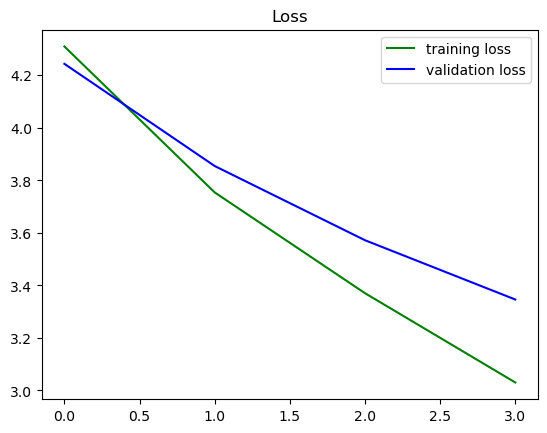

In [57]:
plt.figure()
plt.plot(history.history['loss'], color = 'green', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.legend(loc = 'upper right')
plt.show()

**Plot Observation** 

In this plot we observe that both the training and validation loss decreases as the epochs increases, this indicates that the model is learning and improving its performance on both the training and validation datasets. It suggests that the model is not overfitting or underfitting. 

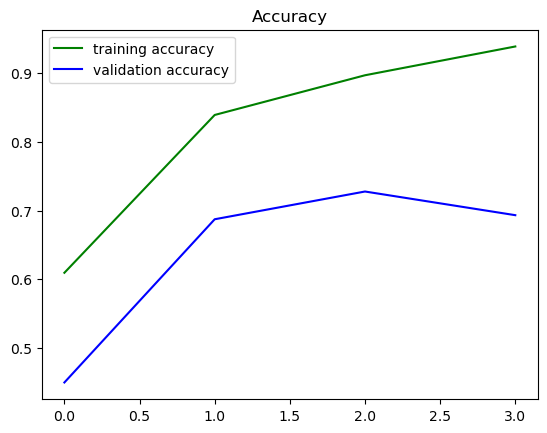

In [56]:
plt.figure()
plt.plot(history.history['accuracy'], color = 'green', label = 'training accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation accuracy')
plt.title('Accuracy')
plt.legend(loc = 'upper left')
plt.show()

**Plot Observation** 

In this plot we observe that the training accuracy increases and the validation accuracy also increases then plateaus, it suggests that the model is effectively learning from the training data and is able to generalize well to unseen data, up to a point. The increase and then plateau in validation accuracy suggests that the model has learned to generalize well to new data and had reached a point where additional training isnt leading to further improvement in performance on the validation set. This could be an indication that the model has reached it capacity for learning from the provided feature and additional improvements might require other optimization with parameters. 

In [45]:
#predictions on the test data
y_pred = model.predict(test_dataset)
y_pred = np.round(y_pred).flatten() #rounding the predictions to 0 or 1 and flattening the array
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred) #creating a confusion matrix

print('Confusion Matrix:')
print(confusion_mtx)

29/29 [==============================] - 12s 399ms/step
Confusion Matrix:
tf.Tensor(
[[247 368]
 [ 90 136]], shape=(2, 2), dtype=int32)


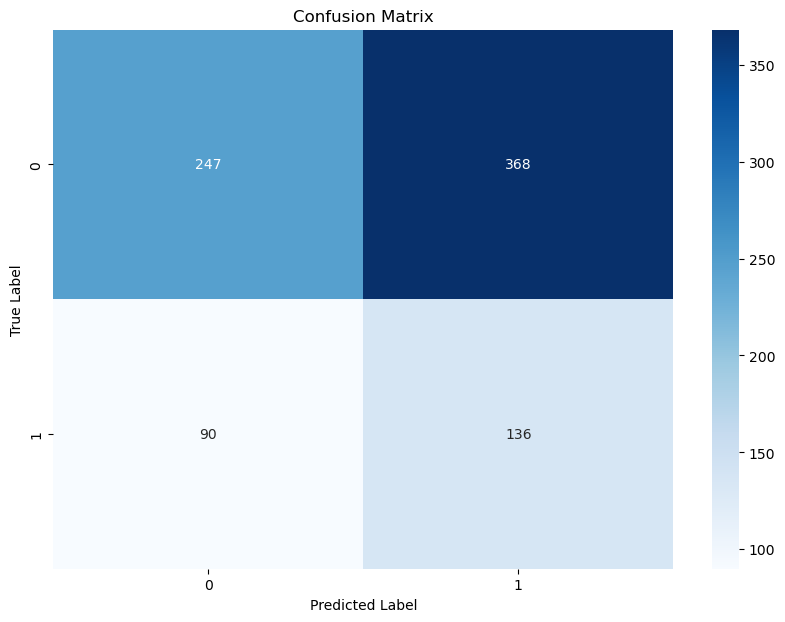

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Save the plot as a file
plt.savefig('confusion_matrix.png')

In [46]:
test_accuracy = accuracy_score(y_test, y_pred)

print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.45541022592152197


In [47]:
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.40      0.52       615
     Class 1       0.27      0.60      0.37       226

    accuracy                           0.46       841
   macro avg       0.50      0.50      0.45       841
weighted avg       0.61      0.46      0.48       841



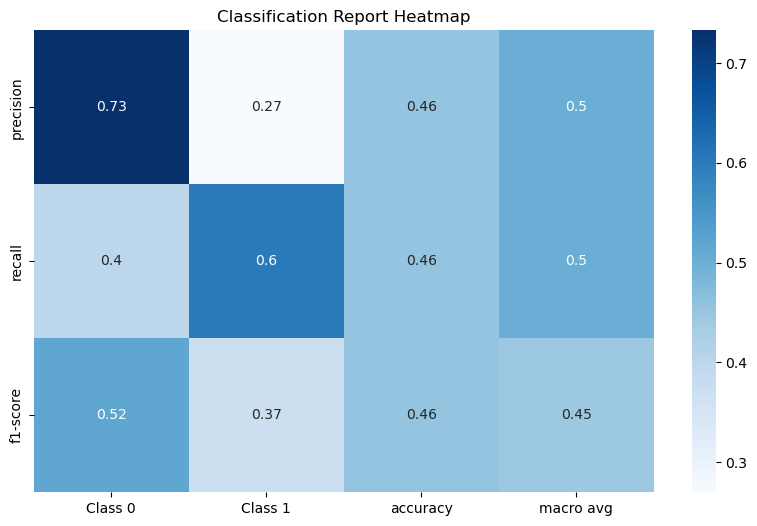

In [58]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

# Convert report to pandas DataFrame
df_report = pd.DataFrame(report).transpose()
df_report = df_report.drop('support', axis=1)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap="Blues")
plt.title('Classification Report Heatmap')

# Save the plot as a file
plt.savefig('classification_report.png')

29/29 [==============================] - 12s 402ms/step


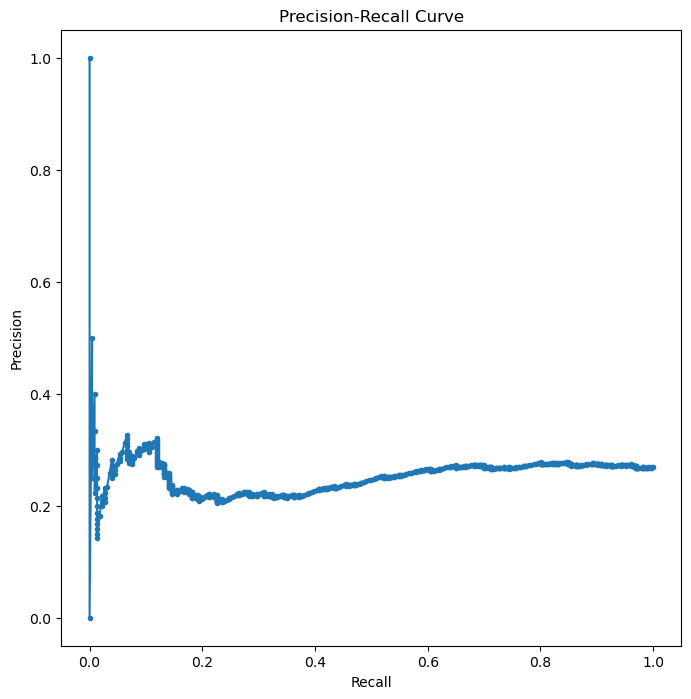

In [50]:
# Predict probabilities for the validation set
y_pred_probs = model.predict(val_dataset)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
indices = [i for i, x in enumerate(y_pred) if x == 1]

In [ ]:
len(indices)

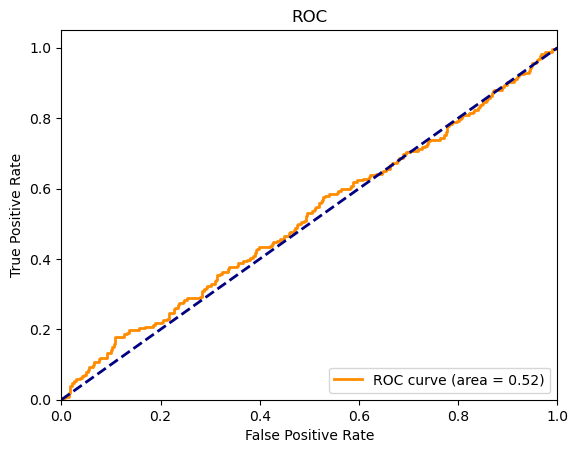

In [51]:
# this code plots the ROC curve, which is used to evaluate the performance of the model. 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

**Plot Observation** 

An AUC of 0.52 in an ROC curve plot indicates that the model's ability to distinguish between the positive and negative classes is slightly better than random guessing, which would have an AUC of 0.5. An AUC of 0.52 is still quite low, suggesting that the model's performance is not very good and improvements to the model is needed such as more tuning hyperparameters. 



## Transfer learning - ResNet50 

In this section, I explore ResNet50, which is a variant of ResNet model which has 50 layers deep. ResNet is a classic neural network used as a backbone for many computer vision tasks. The key innovation of ResNet is the introduction of 'skip connections' which allows the gradient to be directly backpropogated to earlier layers. The main benefit of this is that it helps to mitigate the problem of vanishing gradient, a common issue faced when training deep neural networks where the gradient becomes too small for training to be effective. 
ResNet50 is commonly used for image classification and recognition tasks. In this notebook I will explore using ResNet50 as a feature extractor by freezing the base model to keep the learned features of the base model and then training model on my dataset, only the weights of the custom layers added will be updated during training. 

Additionally, after the top layers have been trained, the other layers can unfreeze in the base model and continue training. This step can sometimes improve performance. However, due to computational resources I currently have and for the sake of completion of this project, I will explore these parameters later. 

In [60]:
base_model = ResNet50(input_shape=(299, 299, 3), include_top=False, weights='imagenet') #loading the ResNet50 model with the imagenet weights

# freeze the base model, so that the pre-trained weights are not updated during training
base_model.trainable = False

In [62]:
model_res = Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu'), 
    Dropout(0.5),
    Dense(1, activation='sigmoid') # output layer with sigmoid activation function for binary classification
])
model_res.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
history = model_res.fit(train_dataset, validation_data = val_dataset, epochs=5, class_weight=class_weights, callbacks=[early_stop])

Epoch 1/5


2024-02-05 21:25:56.249432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 980 of 6724
2024-02-05 21:26:06.268979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 2013 of 6724
2024-02-05 21:26:26.247037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 4134 of 6724
2024-02-05 21:26:36.279400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 5172 of 6724
2024-02-05 21:26:46.296554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 6205 of 6724
2024-02-05 21:26:51.411709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


225/225 [==============================] - 517s 2s/step - loss: 0.9422 - accuracy: 0.7100 - val_loss: 0.8208 - val_accuracy: 0.2687
Epoch 2/5


2024-02-05 21:34:32.424098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 793 of 6724
2024-02-05 21:34:52.430534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 2439 of 6724
2024-02-05 21:35:02.448523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 3296 of 6724
2024-02-05 21:35:22.414684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 5023 of 6724
2024-02-05 21:35:42.251289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


225/225 [==============================] - 580s 2s/step - loss: 0.8198 - accuracy: 0.4823 - val_loss: 0.8190 - val_accuracy: 0.7313
Epoch 3/5


2024-02-05 21:44:12.769804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 857 of 6724
2024-02-05 21:44:22.828508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 1729 of 6724
2024-02-05 21:44:42.792002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 3469 of 6724
2024-02-05 21:45:02.772909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 5237 of 6724
2024-02-05 21:45:12.798466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 6128 of 6724
2024-02-05 21:45:19.393698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


225/225 [==============================] - 579s 2s/step - loss: 0.8187 - accuracy: 0.6212 - val_loss: 0.8182 - val_accuracy: 0.2687
Epoch 4/5


2024-02-05 21:53:51.820280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 679 of 6724
2024-02-05 21:54:01.836077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 1354 of 6724
2024-02-05 21:54:21.833546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 2696 of 6724
2024-02-05 21:54:41.842575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 4179 of 6724
2024-02-05 21:54:51.913009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 4989 of 6724
2024-02-05 21:55:11.813296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may tak

225/225 [==============================] - 621s 2s/step - loss: 0.8175 - accuracy: 0.3105 - val_loss: 0.8166 - val_accuracy: 0.7313
Epoch 5/5


2024-02-05 22:04:13.184326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 741 of 6724
2024-02-05 22:04:23.185447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 1466 of 6724
2024-02-05 22:04:43.179927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 2959 of 6724
2024-02-05 22:04:53.184075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 3692 of 6724
2024-02-05 22:05:03.197542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 4425 of 6724
2024-02-05 22:05:13.223940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may tak

225/225 [==============================] - 634s 2s/step - loss: 0.8164 - accuracy: 0.4063 - val_loss: 0.8146 - val_accuracy: 0.7313


In [64]:
#predictions on the test data
y_pred = model_res.predict(test_dataset)
y_pred = np.round(y_pred).flatten()
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)

print('Confusion Matrix:')
print(confusion_mtx)

29/29 [==============================] - 61s 2s/step
Confusion Matrix:
tf.Tensor(
[[615   0]
 [226   0]], shape=(2, 2), dtype=int32)


In [65]:
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_test, y_pred)

print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.7312722948870393


In [66]:
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      1.00      0.84       615
     Class 1       0.00      0.00      0.00       226

    accuracy                           0.73       841
   macro avg       0.37      0.50      0.42       841
weighted avg       0.53      0.73      0.62       841



/Users/shivanassori/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shivanassori/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shivanassori/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

The ResNet50 is not improving the metrics and this suggests that the model might require more epochs and customized layers for improvements. 

## Conclusion

Both models do not show optimial performance for this project's objective and further tuning and optimizing is needed. The challenge here is that the dataset is imbalanced and in the first CNN model, the model learns the training data well but does not perform well with unseen data. The same can be said for the ResNet50 model. Further optimizing is needed before evaluating and concluding the model results. 